# 2강 EDA - daily mission

### mission - 다양하게 data를 살펴보면서 데이터를 이해하고 분석의 방향성 잡기
- 강의에 소개된 EDA를 직접 코드를 통해 구현해보고, 스스로 다양한 EDA 해보기

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import glob
import os
import random
import re
import datatable as dt
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print("pd version : " + pd.__version__)
print("np version : " + np.__version__)

pd version : 1.1.5
np version : 1.19.5


### set seed

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

### load data

In [4]:
root = '/opt/ml/code/input/'
dataset_path = glob.glob(root + "*.csv")
print(dataset_path)

['/opt/ml/code/input/sample_submission.csv', '/opt/ml/code/input/train.csv']


In [5]:
sample_submission = pd.read_csv(dataset_path[np.where(pd.Series(dataset_path).str.find("submission") != -1)[0][0]])
train = pd.read_csv(dataset_path[np.where(pd.Series(dataset_path).str.find("train") != -1)[0][0]])

# Data summary

2009-12-01 - 2011-11-30일까지 train set으로 주어져 있습니다.

In [6]:
print(train.order_date.min())
print(train.order_date.max())

2009.12.1 10:06
2011.9.9 9:52


unique한 customer_id수는 5914명임을 알 수 있습니다

In [7]:
len(train.customer_id.unique())

5914

- 한명단위로 보면서 Data가 어떻게 구성되어 있는지 살펴보겠습니다. 

- 분단위로 고객의 구매 로그가 기록되어 있습니다. 

- 상품이 다르더라도 같은 시간에 구매했다면 order_id가 같은 것을 볼 수 있습니다. 

- total은 quantity * price임을 알 수 있고, 

- product_id의 경우 데이터 설명과는 다르게 5digit이 아닌 것도 많이 보입니다.




In [8]:
train[train.customer_id == train.customer_id.min()]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
21447,491725,TEST001,This is a test product.,10,2009.12.14 8:34,7.4250,12346,United Kingdom,74.2500
21702,491742,TEST001,This is a test product.,5,2009.12.14 11:00,7.4250,12346,United Kingdom,37.1250
21705,491744,TEST001,This is a test product.,5,2009.12.14 11:02,7.4250,12346,United Kingdom,37.1250
28492,492718,TEST001,This is a test product.,5,2009.12.18 10:47,7.4250,12346,United Kingdom,37.1250
28504,492722,TEST002,This is a test product.,1,2009.12.18 10:55,1.6500,12346,United Kingdom,1.6500
31276,493410,TEST001,This is a test product.,5,2010.1.4 9:24,7.4250,12346,United Kingdom,37.1250
31278,493412,TEST001,This is a test product.,5,2010.1.4 9:53,7.4250,12346,United Kingdom,37.1250
37892,494450,TEST001,This is a test product.,5,2010.1.14 13:50,7.4250,12346,United Kingdom,37.1250
44909,495295,TEST001,This is a test product.,5,2010.1.22 13:30,7.4250,12346,United Kingdom,37.1250
49055,C495800,ADJUST,Adjustment by john on 26/01/2010 17,-1,2010.1.26 17:27,170.7750,12346,United Kingdom,-170.7750


결측치는 존재하지 않습니다.

In [9]:
train.isnull().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

# 1. 어떻게 접근해서 Data를 풀어 나갈 수 있을까?

- 로그 데이터니, 고객의 구매 기록을 시계열 처럼 펼처서 보도록 하겠습니다.
- 그렇게 하기 위해서는 특정 시간별로 행들을 묶어 줘서 봐야합니다.
- 저는 간단하게 월단위로 total을 sum해서 해당 고객의 total값을 봐보도록 하겠습니다.

In [10]:
def make_time_series_data(Input, 기준):
    
    # 기준을 잡습니다. 기준은 여기서 %Y-%m 입니다.
    standard = ['customer_id'] + [기준]
    data = Input.copy()    
    
    
    data[기준] = pd.to_datetime(train.order_date).dt.strftime(기준)    
    data.order_date = pd.to_datetime(data.order_date)
    
    # 월단위의 틀을 만들어주고, 기준으로 aggregation을 해준 다음에 merge를 해줄 것입니다
    times = pd.date_range('2009-12-01', periods= (data.order_date.max() - data.order_date.min()).days + 1, freq='1d')    
    customerid_frame = np.repeat(data.customer_id.unique(), len(times))
    date_frame = np.tile(times, len(data.customer_id.unique()))

    frame = pd.DataFrame({'customer_id':customerid_frame,'order_date':date_frame})
    frame[기준] = pd.to_datetime(frame.order_date).dt.strftime(기준)
    
    # group by
    data_group = data.groupby(standard).sum().reset_index()
    frame_group = frame.groupby(standard).count().reset_index().drop(['order_date'], axis=1)
    
    # merge
    merge = pd.merge(frame_group, data_group, on=standard, how='left').fillna(0)
    merge = merge.rename(columns={기준 : 'standard'})
    return merge

In [11]:
# 해당 코드를 실행하면 제 로컬 기준 RAM이 8.6G정도 사용 됩니다. 
merge_temp = make_time_series_data(train, "%Y-%m")

In [12]:
# 월 단위로 구매기록이 없는 경우는 total이 0, 
# 구매 기록이 있는 경우는 월의 sum으로 묶여 있는 것을 볼 수 있습니다.
# 또한 음수 값도 기록되어있는데 이 경우는 앞선 기간에 환불이 이루어지고, 해당 기간에 환불이 이루어져있다고 합니다.
merge_temp

,customer_id,standard,quantity,price,total
0,12346,2009-12,26.0,31.3500,187.2750
1,12346,2010-01,19.0,200.4750,-22.2750
2,12346,2010-02,0.0,0.0000,0.0000
3,12346,2010-03,5.0,44.6325,44.6325
4,12346,2010-04,0.0,0.0000,0.0000
...,...,...,...,...,...
141931,18287,2011-07,0.0,0.0000,0.0000
141932,18287,2011-08,0.0,0.0000,0.0000
141933,18287,2011-09,0.0,0.0000,0.0000
141934,18287,2011-10,1098.0,78.5895,1768.8000


- 구매기록이 거의 항상 0에 가까운 고객도 있고

- 꽤 주기적으로 구매하는 고객들도 있습니다.

- 또한, 조심해야할 부분이 2012년 12월 total 300 이상 혹은 미만 인데

- 앞선 기간 (예를 들면 2009년 12 ~ 2010년 12)에 많은 구매를 하고, 2011년도에는 구매 기록이 없는 경우 등,

- 이러한 부분들도 유심히 봐야할 것 같다는 생각이 듭니다.

- 혹은, 이 데이터 자체를 sequential한 데이터로 간주하고 다양한 방법들을 사용해 볼 수도 있을 것 같습니다

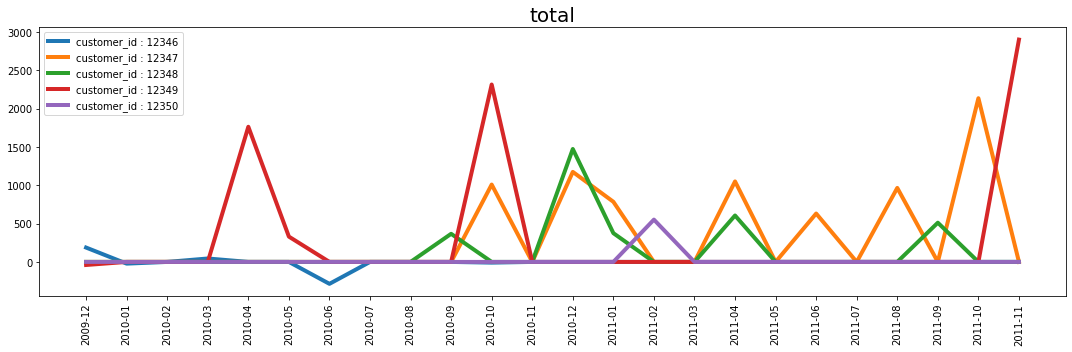

In [13]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 4

# 고객의 5명만 보도록 하겠습니다.
for customer_id in merge_temp.customer_id.unique()[0:5]:
    
    temp = merge_temp[merge_temp.customer_id == customer_id][["standard",'total']]

    plt.plot(temp.standard, temp.total, label="customer_id : " + str(customer_id))       
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("total", size=20)
    plt.tight_layout()

이번에는 값을 smoothing해서 봐보도록 하겠습니다.

위의 plot보다는 그래도 다소 어느정도 구매 경향을 보기가 쉽습니다.

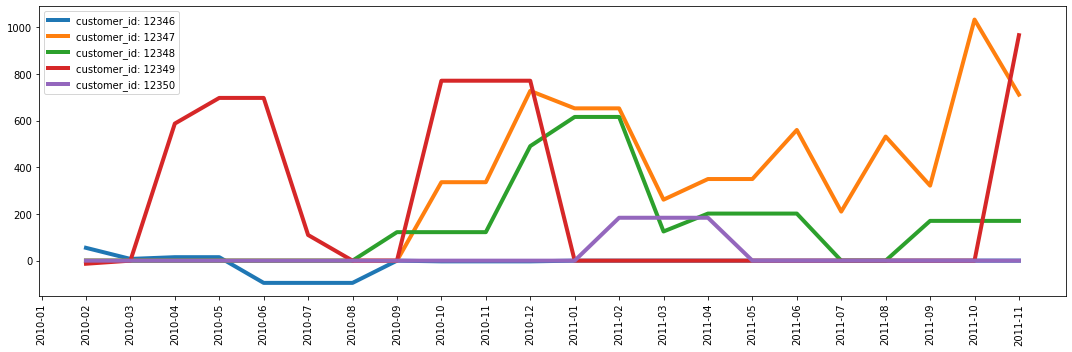

In [14]:
for customer_id in merge_temp.customer_id.unique()[0:5]:
    
    temp = merge_temp[merge_temp.customer_id == customer_id][["standard",'total']]    
    plt.plot(temp.standard, temp.total.rolling(window=3).mean(), label="customer_id: " + str(customer_id))
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()

하지만, 값에 0이 많고 고객마다 구매기록이 천차만별이기 때문에 

단순히 aggregation을 해서 머신러닝을 통해 풀어나가는 것이 더 적합할 수도 있을 겁니다.

In [15]:
train.groupby(['customer_id']).sum().reset_index()

,customer_id,quantity,price,total
0,12346,53,936.3750,-85.3710
1,12347,2775,892.6995,7749.5715
2,12348,2714,318.6150,3332.0100
3,12349,1619,2482.5735,7267.4910
4,12350,197,107.7450,551.7600
...,...,...,...,...
5909,18283,1537,2617.2630,4053.8850
5910,18284,493,191.5485,720.5220
5911,18285,145,165.3300,704.5500
5912,18286,592,505.8075,1960.9095


# 2. 연속형 변수 - total

- 우선은 raw data를 가지고 total을 살펴보도록 하겠습니다. 
- total의 max와 min이 일치하는 것을 통해, 다시 한번 음수값은 환불의 경우임을 대략적으로 추측할 수 있습니다.

Text(60000, 0.001, 'min of total is :-127352.94')

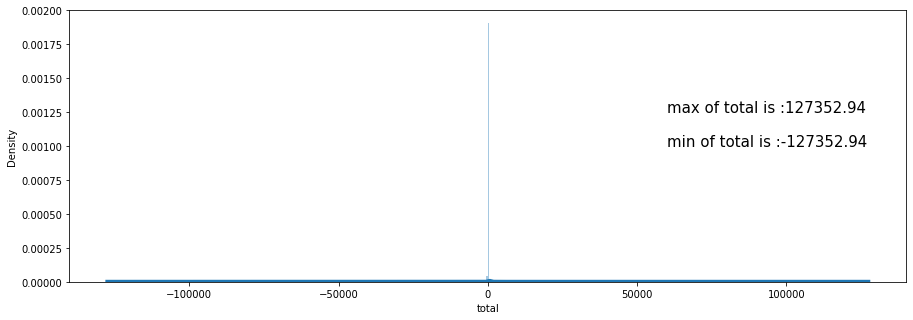

In [16]:
sns.distplot(pd.Series(train.total, name='total'), bins=500)
plt.text(x = 60000, y= 0.00125, s ="max of total is :" + str(train.total.max()), size=15)
plt.text(x = 60000, y= 0.001, s ="min of total is :" + str(train.total.min()), size=15)

- 환불과 total이 어떠한 영향이 있는지 살펴보도록 하겠습니다.
- 각 고객의 구매기록중에 환불의 비율을 C_history라는 data frame으로 만들어 보도록 하겠습니다.

In [17]:
temp = train.sort_values(['customer_id','order_date']).reset_index(drop=True).copy()
temp['C'] = 0
temp.loc[temp.total < 0, 'C'] = 1
temp['year_month'] = pd.to_datetime(temp.order_date).dt.strftime("%Y-%m")

In [18]:
temp_group = temp.groupby(['customer_id','year_month']).sum().reset_index()
C_history = temp_group[temp_group.year_month  <= '2011-11'].groupby(['customer_id']).sum()['C'] / temp.groupby(['customer_id']).count()['C']
valid_target = merge_temp[merge_temp.standard == '2011-11']['total']

In [19]:
C_history

customer_id
12346    0.276596
12347    0.000000
12348    0.000000
12349    0.027778
12350    0.000000
           ...   
18283    0.000000
18284    0.034483
18285    0.000000
18286    0.042857
18287    0.006410
Name: C, Length: 5914, dtype: float64

- 유난히, 환불을 많이 한 고객들이 존재하는 것을 볼 수 있고 대부분은 0.2% 미만입니다. 

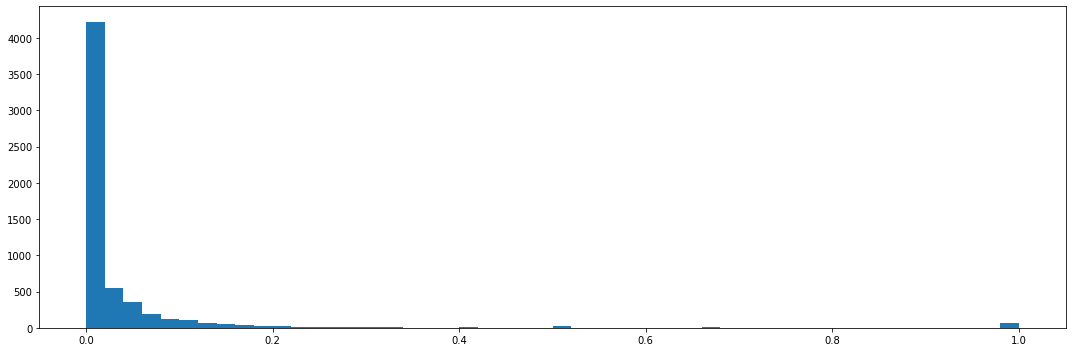

In [20]:
plt.hist(pd.Series(C_history, name='Cancellation_sum before 2011-11'), bins = 50)
plt.tight_layout()

- 환불의 비율이 total에 직접적인 영향이 있는지 궁금해 졌습니다. 

- 환불 비율 자체는 total과 연관성이 없지만, 그렇다면 환불 건수는 어떨까라는 궁금증이 생겼습니다.

Text(0.6, 40000, 'Correlation between x and y is -0.016')

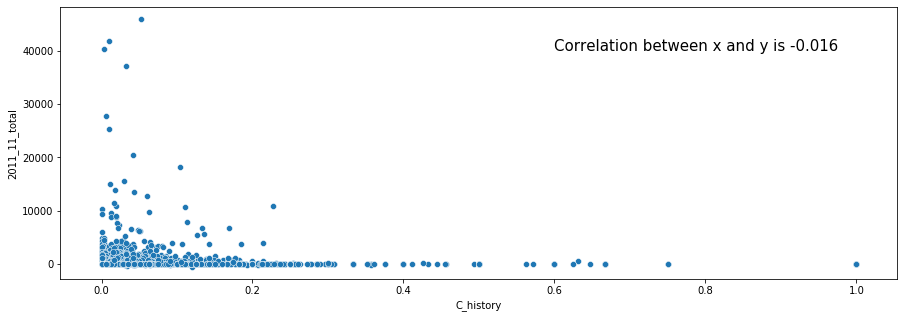

In [21]:
data = pd.DataFrame({'2011_11_total' : np.array(valid_target), 'C_history' : np.array(C_history)})
sns.scatterplot(data=data, x='C_history', y='2011_11_total')
plt.text(0.6, 40000, s="Correlation between x and y is -0.016", size=15)

- 환불 건수 자체는 total과 연관성이 있습니다. 
- 하지만, 이 경우는 환불 건수보다는 구매 건수자체가 많으면 환불 건수자체가 늘어 날 수 있기에 
- 구매 건수와 total이 직접적인 연관이 있다고 볼 수 있습니다.

In [22]:
np.corrcoef(temp.groupby(['customer_id']).count().reset_index()['total'], valid_target)

array([[1.        , 0.52806752],
       [0.52806752, 1.        ]])

# 연속형 변수 - 월별 total

- 우선, total의 시간에 따른 추이를 살펴보자. 전반적으로 9,10,11월로 가면서 상승세가 있습니다.
- 하지만, 오히려, 12월에는 감소한다. 도매상이라 그런지 크리스마스 기간에 장사를 하기 위해 미리 사둔 것인가? 라는 생각을 할 수 있습니다.

In [23]:
train['year_month'] = pd.to_datetime(train.order_date).dt.strftime("%Y-%m")

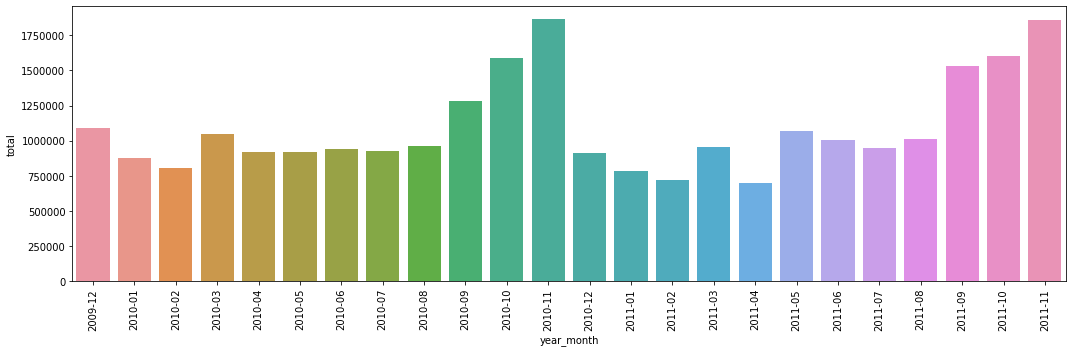

In [24]:
sns.barplot(x=train.groupby(['year_month']).sum().total.index, y=train.groupby(['year_month']).sum().total)
plt.xticks(rotation=90)
plt.tight_layout()

- 그렇다면 국적마다 차이가 있는지 살펴보고 싶다는 생각 또한 듭니다.
- 미국 vs Other로 봤을 때는 큰 차이가 없는 것을 볼 수 있습니다.

In [25]:
train['country_other'] = 1
train.loc[train.country.isin(['United Kingdom']), 'country_other'] = 0

0 length : 5389


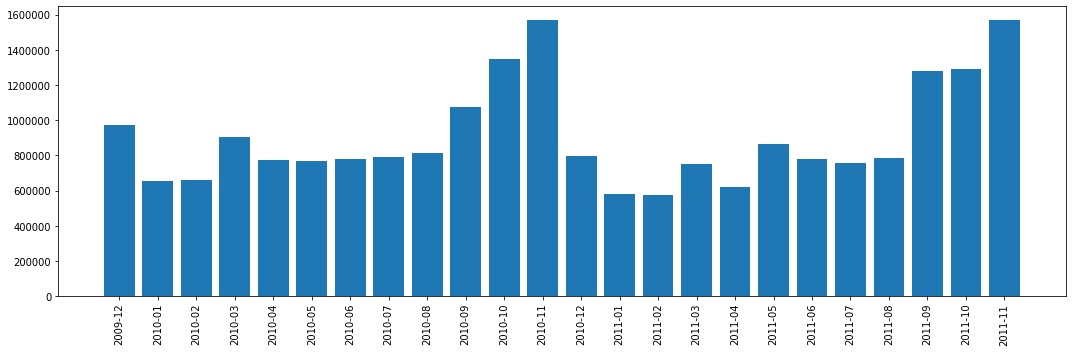

1 length : 526


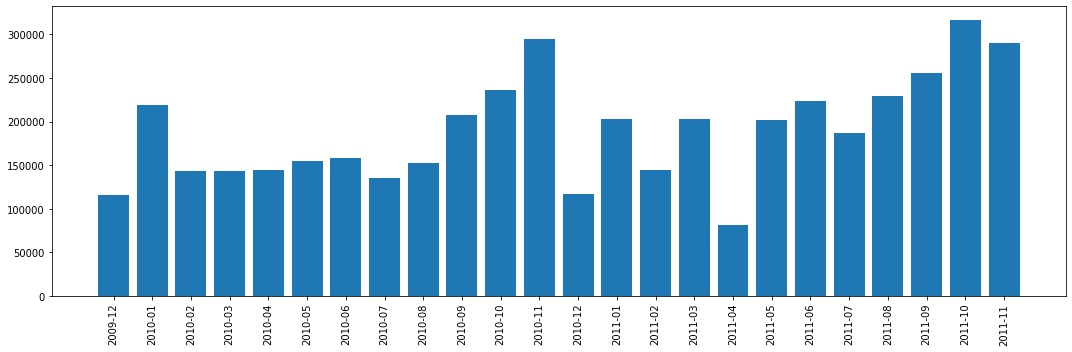

In [26]:
for country in train.country_other.unique():
    
    temp = train[train.country_other == country]
    print(str(country) + " length : " + str(len(temp.customer_id.unique())))
    
    plt.figure()
    plt.bar(x=temp.groupby(['year_month']).sum().total.index, height=temp.groupby(['year_month']).sum().total)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

- 이번에는 월별 total간에 correlation을 보면서, 과연 우리가 타겟팅 하는 월이 어떤 월과 깊은 관련을 맺고 있는지 살펴보도록 하겠습니다.
- 2011년 12월 total은 존재하지 않기에 차선으로 2011년 11월 total을 기준으로 보도록 하겠습니다.
- 2011년 11월은 아무래도 가장 가까운 시기의 데이터와 연관이 있는 것 같기도하고, 작년 비슷한 기간과도 깊은 연관이 있는 것 같습니다.

In [27]:
corr = []
for year_month in merge_temp.standard.unique()[:-1]:
    corr_sub=np.corrcoef(merge_temp[merge_temp.standard == year_month].total, merge_temp[merge_temp.standard == "2011-11"].total)[0][1]
    corr.append(corr_sub)

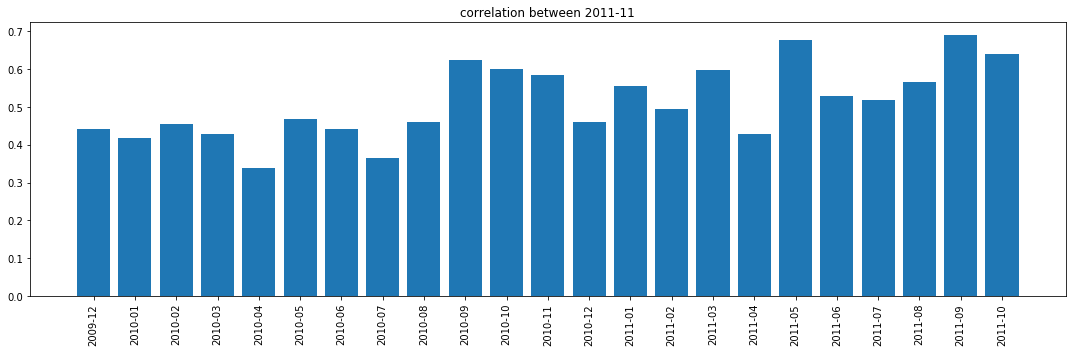

In [28]:
plt.bar(x=merge_temp.standard.unique()[:-1], height=corr)
plt.xticks(rotation=90)
plt.title('correlation between 2011-11');
plt.tight_layout()

- 이번에는 count와 월 별 total의 연관성을 보도록 하겠습니다.
- count의 경우는 가장 가까운 기간의 값과 연관성이 있는 것을 확인할 수 있습니다.

In [29]:
standard = ['customer_id','year_month']
merge_temp = pd.merge(merge_temp, train.groupby(['customer_id','year_month']).count().reset_index()[standard + ['order_id']],
         left_on=['customer_id','standard'],
         right_on=['customer_id','year_month'], how='left').fillna(0)

In [30]:
train.groupby(['customer_id','year_month']).count().reset_index()[standard + ['order_id']]
merge_temp = merge_temp.rename(columns={'order_id':'order_count'})

In [31]:
corr = []
for year_month in merge_temp.standard.unique()[:-1]:
    corr_sub=np.corrcoef(merge_temp[merge_temp.standard == year_month].order_count,
                         merge_temp[merge_temp.standard == "2011-11"].total)[0][1]
    corr.append(corr_sub)

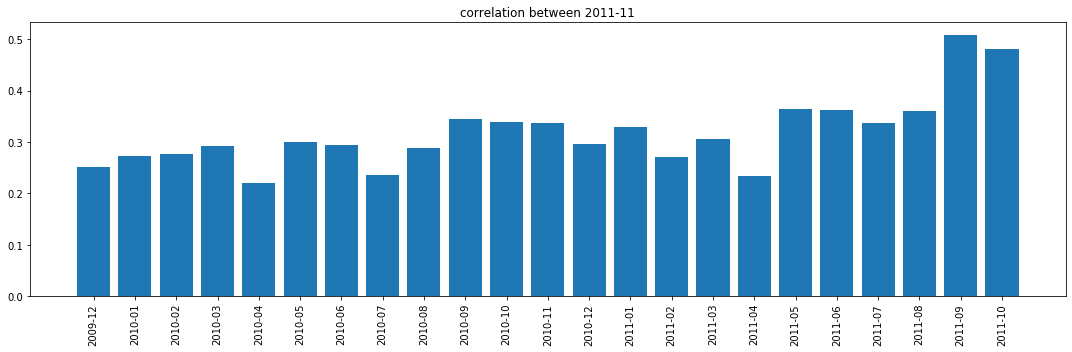

In [32]:
plt.bar(x=merge_temp.standard.unique()[:-1], height=corr)
plt.xticks(rotation=90)
plt.title('correlation between 2011-11');
plt.tight_layout()

# 3. 범주형 변수 - product_id

- product_id는 물품의 대분류인데 이는, 5digit의 수배치가 어떤식으로 구성 되어 있을까라는 궁금증을 가질 수 있습니다. - 
- 그 전에, product_id에 5digit이 없는 경우를 살펴보겠습니다.

In [33]:
train.sort_values(['customer_id'], ascending=True)[0:20].head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_other
78392,499763,15056P,EDWARDIAN PARASOL PINK,1,2010.3.2 13:08,9.8175,12346,United Kingdom,9.8175,2010-03,0
194357,513774,22692,DOORMAT WELCOME TO OUR HOME,1,2010.6.28 13:53,12.3585,12346,United Kingdom,12.3585,2010-06,0
194356,513774,21524,DOORMAT SPOTTY HOME SWEET HOME,1,2010.6.28 13:53,12.3585,12346,United Kingdom,12.3585,2010-06,0
196542,C514024,M,Manual,-1,2010.6.30 11:22,8.5470,12346,United Kingdom,-8.5470,2010-06,0
196543,C514024,M,Manual,-1,2010.6.30 11:22,21.3510,12346,United Kingdom,-21.3510,2010-06,0


In [34]:
product_id_digit = ["".join(re.findall("[0-9]+", code)) for code in train.product_id]
temp = train[[False if len(i) == 5 else True for i in product_id_digit]]
temp.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_other
89,489439,POST,POSTAGE,3,2009.12.1 9:28,29.70,12682,France,89.10,2009-12,1
126,489444,POST,POSTAGE,1,2009.12.1 9:55,232.65,12636,USA,232.65,2009-12,1
173,489447,POST,POSTAGE,1,2009.12.1 10:10,214.50,12362,Belgium,214.50,2009-12,1
611,489526,POST,POSTAGE,6,2009.12.1 11:50,29.70,12533,Germany,178.20,2009-12,1
716,C489535,D,Discount,-1,2009.12.1 12:11,14.85,15299,United Kingdom,-14.85,2009-12,0


In [35]:
temp.product_id.unique()

array(['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'TEST001', 'TEST002',
       'PADS', 'ADJUST', 'ADJUST2', 'SP1002', 'DOT', 'CRUK'], dtype=object)

In [36]:
temp.description.unique()

array(['POSTAGE', 'Discount', 'Manual', 'CARRIAGE', ' Bank Charges',
       'This is a test product.', 'PADS TO MATCH ALL CUSHIONS',
       'Adjustment by john on 26/01/2010 16',
       'Adjustment by john on 26/01/2010 17', 'Bank Charges',
       'Adjustment by Peter on 24/05/2010 1',
       'Adjustment by Peter on Jun 25 2010 ', "KID'S CHALKBOARD/EASEL",
       'DOTCOM POSTAGE', 'CRUK Commission'], dtype=object)

- 이러한 상품을 구매하는 고객들의 경우는 어떤 사람들일까요?!
- 특별한 것이 없다면, 단순히 그 외 상품으로 분류해도 될까? 라는 생각도 듭니다.
- 그렇다면, 이번에 오로지 5digit으로 이루어져있는 product_id만을 살펴보도록 하겠습니다.

In [37]:
train['product_id_clean'] = ["".join(re.findall("[0-9]+", code)) for code in train.product_id]
train['product_id_clean'] = train.product_id_clean.replace(r'^\s*$', np.nan, regex=True)
train.dropna().head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_other,product_id_clean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009.12.1 7:45,11.4675,13085,United Kingdom,137.61,2009-12,0,85048
1,489434,79323P,PINK CHERRY LIGHTS,12,2009.12.1 7:45,11.1375,13085,United Kingdom,133.65,2009-12,0,79323
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009.12.1 7:45,11.1375,13085,United Kingdom,133.65,2009-12,0,79323
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009.12.1 7:45,3.4650,13085,United Kingdom,166.32,2009-12,0,22041
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009.12.1 7:45,2.0625,13085,United Kingdom,49.50,2009-12,0,21232


- 5자리 조합을 생각한다면 너무 많기 때문에 앞의 3자리만을 가지고 product_id의 변수를 어떻게 사용해볼 수 있을지 고민해보도록 하겠습니다.
- 앞의 3자리만을 뽑아서 사용하거나 혹은 2자리 수만을 뽑아서 사용해도 무방할 수 있지 않을까요?!

In [38]:
train['product_id_clean_2'] = [code[0:3] for code in train.product_id_clean.astype("str")]
train['product_id_clean_3'] = [code[0:2] for code in train.product_id_clean.astype("str")]
train.product_id_clean_2.head()

0    850
1    793
2    793
3    220
4    212
Name: product_id_clean_2, dtype: object

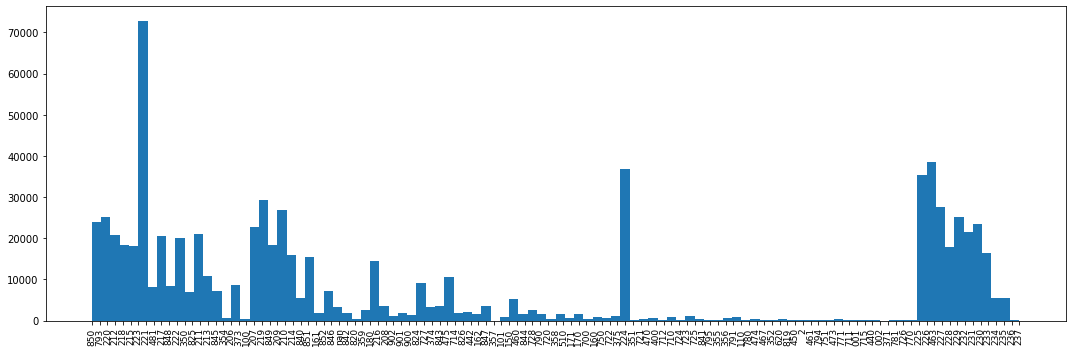

In [39]:
plt.hist(train.product_id_clean_2, bins=100)
plt.xticks(rotation=90, size=9)
plt.tight_layout()



- 3자리 까지만 뽑아서 해당 product_id의 description을 wordcloud로 살펴보면서, 과연 묶을 수 있을지 살펴보겠습니다.
- 210과 850을 보면, 약간 비슷한 단어가 빈도높게 나오는 것을 볼 수 있습니다.

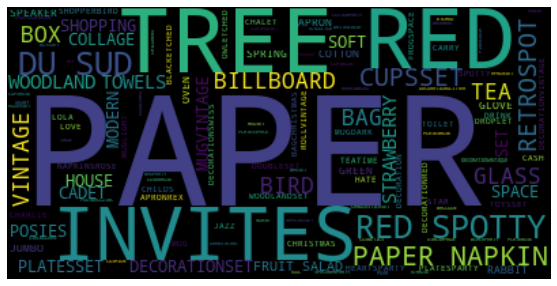

In [41]:
word_list = train[train.product_id_clean_2 == '210'].description.unique()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(["IMAGES"])

wordcloud = WordCloud(stopwords=stopwords).generate("".join(word_list))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

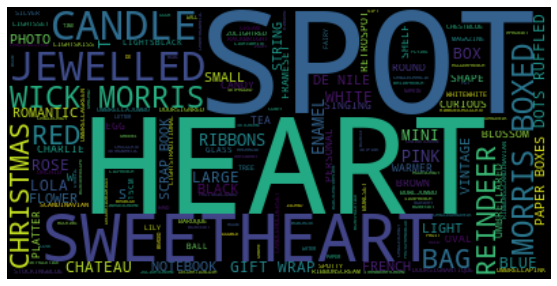

In [42]:
word_list = train[train.product_id_clean_2 == '850'].description.unique()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(["IMAGES"])

wordcloud = WordCloud(stopwords=stopwords).generate("".join(word_list))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 3. 범주형 변수 - product_id 2

- 그렇다면 고객 마다, 구매하는 상품이 유사한지, 혹은 유난히 다른 사람들이 사지 않는 상품을 주로 구매하는 고객이 있을까요?
- 대부분이 도매상이기 때문에(개인적으로 구매하는 일반 고객도 있을 수 있습니다. 이러한 것들은 혹시 구매건수를 통해 어느정도 알 수 있을까요?!) 주로 취급하는 상품이 다른 고객들도 분명 계실 것 같습니다



In [43]:
# product_id에서 앞 2자리만 뽑아 one hotencoding화 한이후에 year_month로 묶어 count를 세어줍니다.
temp = pd.concat([train[['customer_id','year_month']], 
      pd.get_dummies(train.product_id_clean_3)], axis=1).groupby(['customer_id','year_month']).sum().reset_index(drop=False)

In [44]:
# 구매기록이 없는 경우에 0을 채워주기 위해서 앞서 만들었던 data frame과 merge해줍니다.
temp = pd.merge(merge_temp[['customer_id', 'standard']], temp, left_on=['customer_id', 'standard'],
         right_on=['customer_id','year_month'], how='left').fillna(0)

<Figure size 1080x360 with 0 Axes>

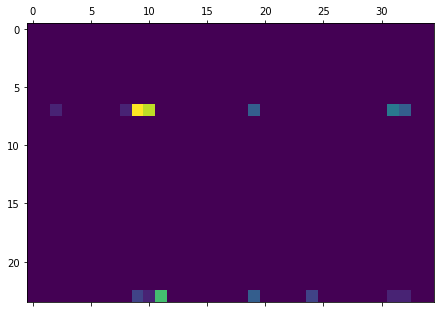

<Figure size 1080x360 with 0 Axes>

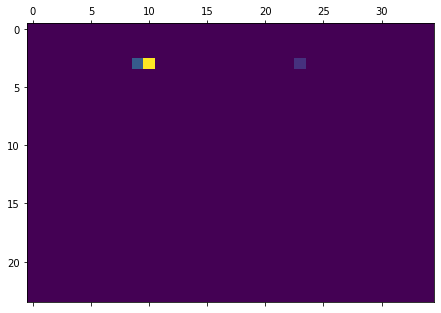

<Figure size 1080x360 with 0 Axes>

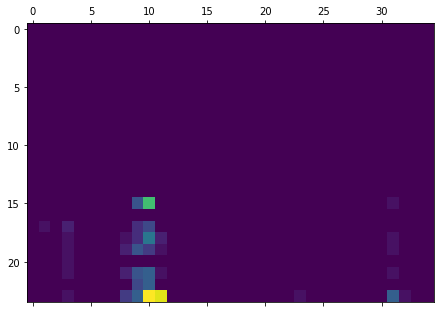

<Figure size 1080x360 with 0 Axes>

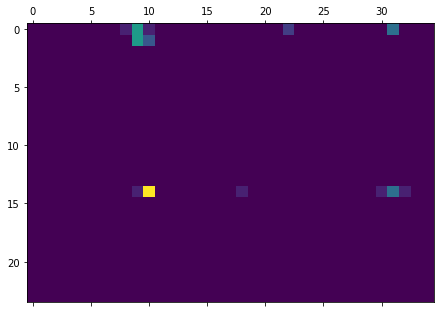

<Figure size 1080x360 with 0 Axes>

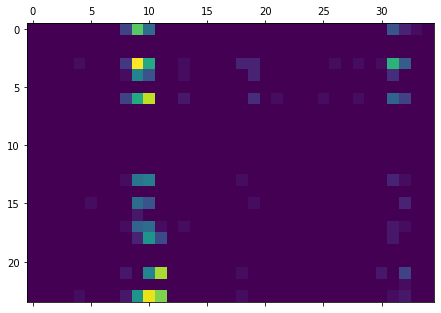

<Figure size 1080x360 with 0 Axes>

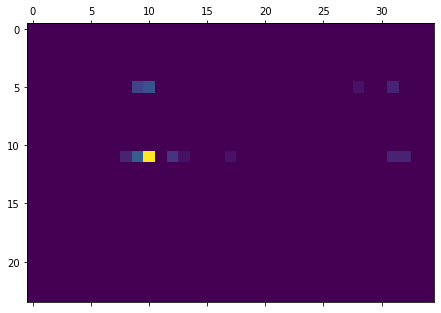

<Figure size 1080x360 with 0 Axes>

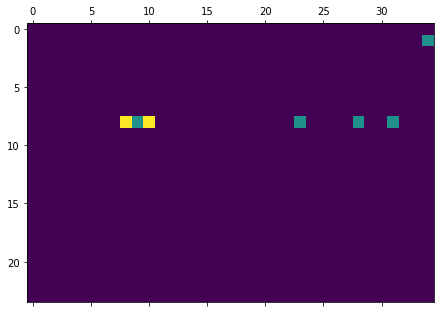

<Figure size 1080x360 with 0 Axes>

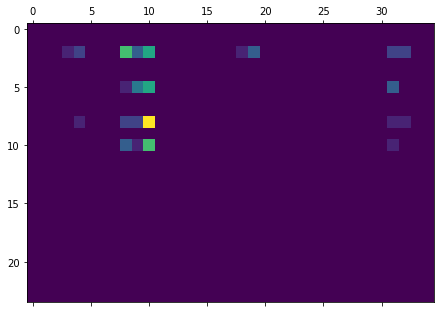

<Figure size 1080x360 with 0 Axes>

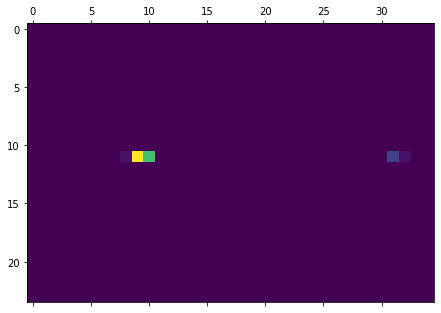

<Figure size 1080x360 with 0 Axes>

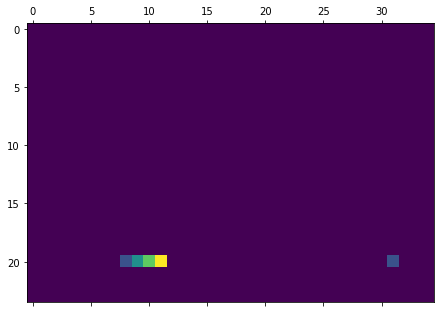

In [45]:
for customer in temp.customer_id.unique()[600:610]:
    temp_customer = temp[temp.customer_id == customer]
    plt.figure()
    plt.matshow(temp_customer.drop(['customer_id','standard','year_month'], axis=1))
    plt.show()

- 고객마다 구매기록이 천차만별이다 보니, 이를 통해 고객들을 clustering하거나 뭔가 유의미한 것을 보기는 쉽진 않아보입니다!
- 오히려 이를 통해 꾸준히 구매를 하는 고객인지, 듬성 듬성 구매를 하는 고객인지 이러한 것들이 조금 더 눈에 띄게 구분되어 보입니다.

# Summary

위의 EDA를 통해 Data에 대한 전반적인 이해를 시도해 보았습니다.

데이터를 보고 궁금증을 가지고 직접 알아보고, 다시 또 다른 궁금증을 가지고 EDA를 하면서 살펴보고 있습니다.

이 과정에서 쓸만한 변수를 생각하고 어떤 모델을 사용할지 생각해 볼 수 있습니다.

멘티 여러분들 스스로 데이터를 파헤쳐 나가면서 데이터를 이해하고, 좋은 변수들을 찾아내서 좋은 성능의 모델을 만드셨으면 좋겠습니다!